In [6]:
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# from tensorflow.keras import datasets, layers, models
# import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_csv('data/data.csv', parse_dates=['kickoff_time'])

In [7]:
cutoff = 30

train_data = data[data['round'] < cutoff].drop('round', axis=1)
test_data = data[data['round'] >= cutoff].drop('round', axis=1)

In [9]:
scaler = MinMaxScaler()

scaler.fit(train_data[bounded_vars])

MinMaxScaler()

In [14]:
np.unique(scaler.transform(train_data[bounded_vars])[:, 1])

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [8]:
wrangling_columns = ['element', 'round', 'position']

no_scaling = [
    'was_home', 'clean_sheets', 'yellow_cards', 'red_cards',
    'starts']

bounded_vars = ['minutes', 'bonus']  # minmax scaling

out_metrics = [
    'penalties_missed', 'goals_scored', 'assists', 'expected_goals',
    'expected_assists', 'expected_goal_involvements']

gkp_metrics = ['penalties_saved', 'saves']

count_vars = ['goals_conceded', 'own_goals']

fantasy_metrics = [
    'bps', 'influence', 'creativity', 'threat', 'ict_index', 'value',
    'transfers_balance', 'selected', 'transfers_in', 'transfers_out', 'total_points']

x_metrics = ['expected_goals_conceded']

time_metrics = ['time_diffs']

<Axes: xlabel='creativity', ylabel='total_points'>

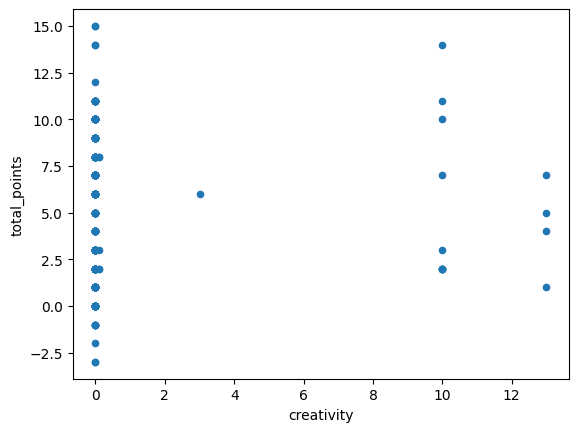

In [5]:
data[(data['position'] == 'GKP') & (data['minutes'] >= 0)].plot.scatter(x='creativity', y='total_points')

<Axes: ylabel='Frequency'>

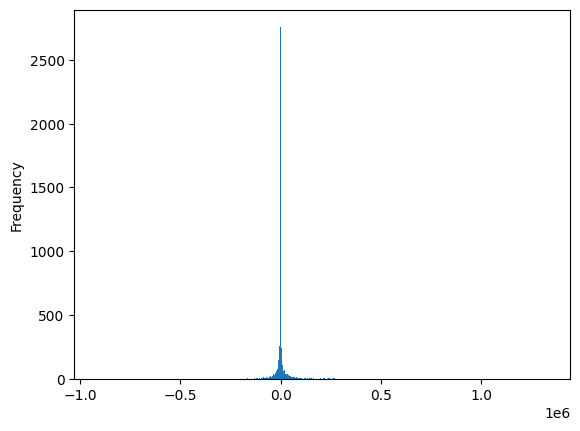

In [28]:
total_points = data['transfers_balance']

total_points.plot.hist(bins=1000)